In [58]:
import pandas as pd #Dataframe, Series
import numpy as np

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import seaborn as sns

import graphviz
import pydotplus
import io

from scipy import misc

from sklearn.metrics import accuracy_score

import spotipy
import spotipy.util as util
sp = spotipy.Spotify() 
from spotipy.oauth2 import SpotifyClientCredentials 

%matplotlib inline

### Login

In [59]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util

client_id = '164fe11263da4ce8b39cb03311385ce6'
client_secret = '448a0146206e4b718e4bcc0865efcd29'
redirect_uri='http://localhost:8080/callback'
username = '5865b9eadfc54092'
scope = 'user-library-read playlist-read-private'


#Credentials to access the Spotify Music Data
from spotipy.oauth2 import SpotifyOAuth
import spotipy

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id,
                                               client_secret,
                                               redirect_uri,
                                               scope = 'user-library-read playlist-read-private'))

### Input Data into Model

- gathering good and bad playlists
- The method signature is sp.user_playlist('user', 'playlist_id')
- To do this go to your good and bad playlists and copy the links.
    - An example spotify link: https://open.spotify.com/user/1287242681/playlist/5OdH7PmotfAO7qDGxKdw3J
    - The user is the number after user/ and the playlist id is after the playlist/.

In [60]:
good_playlist = sp.user_playlist("1287242681", "4xsezTLL6nTw71prwB0IWE")
bad_playlist = sp.user_playlist("1287242681", "37i9dQZF1EIeBK96mJllYR")

# https://open.spotify.com/playlist/4xsezTLL6nTw71prwB0IWE?si=1644f32f1e57424b
# https://open.spotify.com/playlist/37i9dQZF1EIeBK96mJllYR?si=6fc5535b01db45c4

In [61]:
#Get the good song id's out of the good playlists, need it for the audio features call.
good_tracks = good_playlist["tracks"]
good_songs = good_tracks["items"] 
while good_tracks['next']:
    good_tracks = sp.next(good_tracks)
    for item in good_tracks["items"]:
        good_songs.append(item)
good_ids = [] 
print(len(good_songs))
for i in range(len(good_songs)):
    print(good_songs[i]['track']['id'])
    good_ids.append(good_songs[i]['track']['id'])
# good_tracks

114
0kiMIjBpMFgh9yuKJawjX4
5WL6VbqrAs7qYsMkCvShoN
2uTPHrN8zqYnHUb6Wuz1FC
4o5fJRw7WBtHGUTiwLnARq
38qAaZpFyxhPoLnsr6d7bX
6ZyEZpsnv8mwiMEeNRK2oq
7jTEQrKXaazC3CGQ4gI6xN
32nw9Qc5rYjsPWGLy14Yh5
19iSfXqouWsiUohcSOnl8L
3GPYUPEP8O4cMn7mLA9RX1
43mulJ5Q7ECMNpqpmtflNt
76lT30VRv09h5MQp5snmsb
2XI8lC8cFVMRFzJtQAicuC
4cTW1QdgCJiqE1Pvreb80L
6BA2JM59JObFjHNvLK2KOg
2HjcFrEc1qBZEhWKlEgbqd
2cGpsrs0iI3IHZfxdwYbrL
2TiXhYBjWNHfa2wwGw6tAS
2uIxdrO5xr6Fqn6l8V4I3i
4lICIWB6yERkWF9ox3FJM0
0MTvuVBPVvymPy5NbBPZ8S
3cky6IEiCby6PlTAKHz22N
1lewHWUDmqsHvLhf5Vz4hF
2yAOaUhMCX7irO3N1ygHs4
4AU5O9RJxROGFVFDHsWHqa
5YDbSfN5oKWBoeyf9nBA38
506Lwo8JyTAhxbWDb1Qf3W
5oHUo5euGbzVguVUAiG4Bw
2yHDul3lm4cJctPrQO49Ng
6n6OzalpQtkKKXlwB0ndJF
3SD0QmTAKVFyyYjGfTjhWL
1tRLXy4R5YDnwATpNIkz1R
6WJo5i4PTNqMPD4lzboWRw
3H14v9PiWGskHdaH6sUL7F
1BpgjqfWHrWO4IAOClvxAr
4mz5sOi3htRQVIz5V067OH
5EZGlRM9in9zx7IK9qaFQv
20Tc62gPQKX6Rb7gfZuVbI
2gkudYDDVwdmSjNVp0okOM
30ZhlPBuHUu7C06w4NQGKP
5JjqVWjYt7NarZZBVQ7UMw
6TR0FGw4zhlGbQALN065AI
1a8tAQAzHIPQ00OPBXGWPz
2vfSCFv

In [62]:
#Now do the same thing for the bad playlist
bad_tracks = bad_playlist["tracks"]
bad_songs = bad_tracks["items"] 
while bad_tracks['next']:
    bad_tracks = sp.next(bad_tracks)
    for item in bad_tracks["items"]:
        bad_songs.append(item)
bad_ids = [] 
print(len(bad_songs))
for i in range(len(bad_songs)):
    print(bad_songs[i]['track']['id'])
    bad_ids.append(bad_songs[i]['track']['id'])

50
5xWGpcvb1q6N1IIJwtDNRF
2zUKhXh78KzEnC7NzigNjn
3p2R6sc2J9ESsqddoWJGoh
4ufo1TzYrfY36snufI4rWA
4jNkEyCYTfCavAOHgtBsCz
26kXONuhWX8sutaxnmcpPg
1cSXzDZt8vzuUp2XREQEJN
4RFiNPW3ND94D0cravoOFN
59HKKV0eD3UPJ3RCG5qFcc
27fP4B7l2GsEcUqgKac8Q1
1OGxXjPkblmZPjoi17xN6T
4poYvYKOKtpAOoXSIYeU0A
4JoWZaASliMo4WISlnt8pL
0xJCFn6sMc3jgPmraCK0l6
1l1lxI5SHosgPk9CeGDneh
6weT0OACEb3e4KLQJInf4I
7sgbBeINoJ4TDUDIloK9li
1o5evgltJughVgrPinzAOV
4txoYsjsBhES9FKOMqrJeE
1xjgcaRHGGpCFiOf7hDlLQ
5nu6DLPJ91h2lSKQuPDzYd
09xzup1C7H52KnSw0367rz
5WJEoex0MzOYDk66Knt2iz
2g8pMDC1lck27f85wSnO13
6aRlZoOO6dqXQtqq2wiQZ1
3IsASNnv8A9dS7GoZy1LY9
0tEr9vAe483LIkxQOEk55R
693l6uEsdczvJ32j7Ib2ba
7yUv6nCxiV1pEa5MdybU5b
36MlATpv8FBf6jZi2H5PtM
0ObItSI2K1SP6uJPdHSyb9
6znNNBVOlr13WHFx2ltWEw
2PyjUxnsU3VA6KtumvtaES
13Ak4if5T1MlYgqNIay1wN
1v5ux3K8vE1CWxDa0PVyGu
48N0qA4BX71bCNFTRq1CbG
1CKihAZUQIsMAlVHgqlRaf
6NY44HcOMQB3FzWPxpl9Op
1HTEtJyzBfaAE5Og0zVzPR
2WysCkH85JSZbWAAIsLQWE
2LCTb56JCmr7ibz3MN4XSh
2RfXoyDFnKXrlV7jccut2j
46vOwVfosQJ4bFdY1ryVnU
2pThZ2eW

In [63]:
good_ids

['0kiMIjBpMFgh9yuKJawjX4',
 '5WL6VbqrAs7qYsMkCvShoN',
 '2uTPHrN8zqYnHUb6Wuz1FC',
 '4o5fJRw7WBtHGUTiwLnARq',
 '38qAaZpFyxhPoLnsr6d7bX',
 '6ZyEZpsnv8mwiMEeNRK2oq',
 '7jTEQrKXaazC3CGQ4gI6xN',
 '32nw9Qc5rYjsPWGLy14Yh5',
 '19iSfXqouWsiUohcSOnl8L',
 '3GPYUPEP8O4cMn7mLA9RX1',
 '43mulJ5Q7ECMNpqpmtflNt',
 '76lT30VRv09h5MQp5snmsb',
 '2XI8lC8cFVMRFzJtQAicuC',
 '4cTW1QdgCJiqE1Pvreb80L',
 '6BA2JM59JObFjHNvLK2KOg',
 '2HjcFrEc1qBZEhWKlEgbqd',
 '2cGpsrs0iI3IHZfxdwYbrL',
 '2TiXhYBjWNHfa2wwGw6tAS',
 '2uIxdrO5xr6Fqn6l8V4I3i',
 '4lICIWB6yERkWF9ox3FJM0',
 '0MTvuVBPVvymPy5NbBPZ8S',
 '3cky6IEiCby6PlTAKHz22N',
 '1lewHWUDmqsHvLhf5Vz4hF',
 '2yAOaUhMCX7irO3N1ygHs4',
 '4AU5O9RJxROGFVFDHsWHqa',
 '5YDbSfN5oKWBoeyf9nBA38',
 '506Lwo8JyTAhxbWDb1Qf3W',
 '5oHUo5euGbzVguVUAiG4Bw',
 '2yHDul3lm4cJctPrQO49Ng',
 '6n6OzalpQtkKKXlwB0ndJF',
 '3SD0QmTAKVFyyYjGfTjhWL',
 '1tRLXy4R5YDnwATpNIkz1R',
 '6WJo5i4PTNqMPD4lzboWRw',
 '3H14v9PiWGskHdaH6sUL7F',
 '1BpgjqfWHrWO4IAOClvxAr',
 '4mz5sOi3htRQVIz5V067OH',
 '5EZGlRM9in9zx7IK9qaFQv',
 

In [64]:
bad_ids

['5xWGpcvb1q6N1IIJwtDNRF',
 '2zUKhXh78KzEnC7NzigNjn',
 '3p2R6sc2J9ESsqddoWJGoh',
 '4ufo1TzYrfY36snufI4rWA',
 '4jNkEyCYTfCavAOHgtBsCz',
 '26kXONuhWX8sutaxnmcpPg',
 '1cSXzDZt8vzuUp2XREQEJN',
 '4RFiNPW3ND94D0cravoOFN',
 '59HKKV0eD3UPJ3RCG5qFcc',
 '27fP4B7l2GsEcUqgKac8Q1',
 '1OGxXjPkblmZPjoi17xN6T',
 '4poYvYKOKtpAOoXSIYeU0A',
 '4JoWZaASliMo4WISlnt8pL',
 '0xJCFn6sMc3jgPmraCK0l6',
 '1l1lxI5SHosgPk9CeGDneh',
 '6weT0OACEb3e4KLQJInf4I',
 '7sgbBeINoJ4TDUDIloK9li',
 '1o5evgltJughVgrPinzAOV',
 '4txoYsjsBhES9FKOMqrJeE',
 '1xjgcaRHGGpCFiOf7hDlLQ',
 '5nu6DLPJ91h2lSKQuPDzYd',
 '09xzup1C7H52KnSw0367rz',
 '5WJEoex0MzOYDk66Knt2iz',
 '2g8pMDC1lck27f85wSnO13',
 '6aRlZoOO6dqXQtqq2wiQZ1',
 '3IsASNnv8A9dS7GoZy1LY9',
 '0tEr9vAe483LIkxQOEk55R',
 '693l6uEsdczvJ32j7Ib2ba',
 '7yUv6nCxiV1pEa5MdybU5b',
 '36MlATpv8FBf6jZi2H5PtM',
 '0ObItSI2K1SP6uJPdHSyb9',
 '6znNNBVOlr13WHFx2ltWEw',
 '2PyjUxnsU3VA6KtumvtaES',
 '13Ak4if5T1MlYgqNIay1wN',
 '1v5ux3K8vE1CWxDa0PVyGu',
 '48N0qA4BX71bCNFTRq1CbG',
 '1CKihAZUQIsMAlVHgqlRaf',
 

In [65]:
print(sp.audio_features(good_ids[0]))

[{'danceability': 0.982, 'energy': 0.478, 'key': 5, 'loudness': -7.658, 'mode': 0, 'speechiness': 0.202, 'acousticness': 0.118, 'instrumentalness': 0.74, 'liveness': 0.112, 'valence': 0.567, 'tempo': 122.007, 'type': 'audio_features', 'id': '0kiMIjBpMFgh9yuKJawjX4', 'uri': 'spotify:track:0kiMIjBpMFgh9yuKJawjX4', 'track_href': 'https://api.spotify.com/v1/tracks/0kiMIjBpMFgh9yuKJawjX4', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/0kiMIjBpMFgh9yuKJawjX4', 'duration_ms': 412133, 'time_signature': 4}]


In [66]:
for i in range(0,len(good_ids),50):
    audio_features = sp.audio_features(good_ids[i:i+50])
    print(audio_features)
    

[{'danceability': 0.982, 'energy': 0.478, 'key': 5, 'loudness': -7.658, 'mode': 0, 'speechiness': 0.202, 'acousticness': 0.118, 'instrumentalness': 0.74, 'liveness': 0.112, 'valence': 0.567, 'tempo': 122.007, 'type': 'audio_features', 'id': '0kiMIjBpMFgh9yuKJawjX4', 'uri': 'spotify:track:0kiMIjBpMFgh9yuKJawjX4', 'track_href': 'https://api.spotify.com/v1/tracks/0kiMIjBpMFgh9yuKJawjX4', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/0kiMIjBpMFgh9yuKJawjX4', 'duration_ms': 412133, 'time_signature': 4}, {'danceability': 0.662, 'energy': 0.429, 'key': 4, 'loudness': -12.522, 'mode': 1, 'speechiness': 0.0437, 'acousticness': 0.0418, 'instrumentalness': 0.882, 'liveness': 0.105, 'valence': 0.15, 'tempo': 121.034, 'type': 'audio_features', 'id': '5WL6VbqrAs7qYsMkCvShoN', 'uri': 'spotify:track:5WL6VbqrAs7qYsMkCvShoN', 'track_href': 'https://api.spotify.com/v1/tracks/5WL6VbqrAs7qYsMkCvShoN', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/5WL6VbqrAs7qYsMkCvShoN', 'duration

In [67]:
features = []
for i in range(0,len(good_ids),50):
    audio_features = sp.audio_features(good_ids[i:i+50])
    for track in audio_features:
        features.append(track)
        features[-1]['target'] = 1

In [68]:
features

[{'danceability': 0.982,
  'energy': 0.478,
  'key': 5,
  'loudness': -7.658,
  'mode': 0,
  'speechiness': 0.202,
  'acousticness': 0.118,
  'instrumentalness': 0.74,
  'liveness': 0.112,
  'valence': 0.567,
  'tempo': 122.007,
  'type': 'audio_features',
  'id': '0kiMIjBpMFgh9yuKJawjX4',
  'uri': 'spotify:track:0kiMIjBpMFgh9yuKJawjX4',
  'track_href': 'https://api.spotify.com/v1/tracks/0kiMIjBpMFgh9yuKJawjX4',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/0kiMIjBpMFgh9yuKJawjX4',
  'duration_ms': 412133,
  'time_signature': 4,
  'target': 1},
 {'danceability': 0.662,
  'energy': 0.429,
  'key': 4,
  'loudness': -12.522,
  'mode': 1,
  'speechiness': 0.0437,
  'acousticness': 0.0418,
  'instrumentalness': 0.882,
  'liveness': 0.105,
  'valence': 0.15,
  'tempo': 121.034,
  'type': 'audio_features',
  'id': '5WL6VbqrAs7qYsMkCvShoN',
  'uri': 'spotify:track:5WL6VbqrAs7qYsMkCvShoN',
  'track_href': 'https://api.spotify.com/v1/tracks/5WL6VbqrAs7qYsMkCvShoN',
  'analysis_url

In [69]:
#Here is where we get all of the audio_features for the tracks on the good and bad playlists.
features = []
inSavedTracks = []
j = 0
for i in range(0,len(good_ids),50):
    audio_features = sp.audio_features(good_ids[i:i+50])
    for track in audio_features:
        print(track)
        features.append(track)
        track = good_songs[j]
        j= j+1
        features[-1]['trackPopularity'] = track['track']['popularity']
        features[-1]['artistPopularity'] = sp.artist(track['track']['artists'][0]['id'])['popularity']
        features[-1]['target'] = 1
j = 0
for i in range(0,len(bad_ids),50):
    audio_features = sp.audio_features(bad_ids[i:i+50])
    for track in audio_features:
        print(track)
        features.append(track)
        track = good_songs[j]
        j= j+1
        features[-1]['trackPopularity'] = track['track']['popularity']
        features[-1]['artistPopularity'] = sp.artist(track['track']['artists'][0]['id'])['popularity']
        features[-1]['target'] = 0

{'danceability': 0.982, 'energy': 0.478, 'key': 5, 'loudness': -7.658, 'mode': 0, 'speechiness': 0.202, 'acousticness': 0.118, 'instrumentalness': 0.74, 'liveness': 0.112, 'valence': 0.567, 'tempo': 122.007, 'type': 'audio_features', 'id': '0kiMIjBpMFgh9yuKJawjX4', 'uri': 'spotify:track:0kiMIjBpMFgh9yuKJawjX4', 'track_href': 'https://api.spotify.com/v1/tracks/0kiMIjBpMFgh9yuKJawjX4', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/0kiMIjBpMFgh9yuKJawjX4', 'duration_ms': 412133, 'time_signature': 4}
{'danceability': 0.662, 'energy': 0.429, 'key': 4, 'loudness': -12.522, 'mode': 1, 'speechiness': 0.0437, 'acousticness': 0.0418, 'instrumentalness': 0.882, 'liveness': 0.105, 'valence': 0.15, 'tempo': 121.034, 'type': 'audio_features', 'id': '5WL6VbqrAs7qYsMkCvShoN', 'uri': 'spotify:track:5WL6VbqrAs7qYsMkCvShoN', 'track_href': 'https://api.spotify.com/v1/tracks/5WL6VbqrAs7qYsMkCvShoN', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/5WL6VbqrAs7qYsMkCvShoN', 'duration_m

### Model Training and Data Modeling

In [70]:
trainingData = pd.DataFrame(features)
trainingData.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,type,id,uri,track_href,analysis_url,duration_ms,time_signature,trackPopularity,artistPopularity,target
0,0.982,0.478,5,-7.658,0,0.2020,0.11800,0.740,0.1120,0.567,...,audio_features,0kiMIjBpMFgh9yuKJawjX4,spotify:track:0kiMIjBpMFgh9yuKJawjX4,https://api.spotify.com/v1/tracks/0kiMIjBpMFgh...,https://api.spotify.com/v1/audio-analysis/0kiM...,412133,4,0,46.0,1
1,0.662,0.429,4,-12.522,1,0.0437,0.04180,0.882,0.1050,0.150,...,audio_features,5WL6VbqrAs7qYsMkCvShoN,spotify:track:5WL6VbqrAs7qYsMkCvShoN,https://api.spotify.com/v1/tracks/5WL6VbqrAs7q...,https://api.spotify.com/v1/audio-analysis/5WL6...,257851,4,54,56.0,1
2,0.847,0.346,7,-11.243,1,0.0936,0.00339,0.918,0.0704,0.404,...,audio_features,2uTPHrN8zqYnHUb6Wuz1FC,spotify:track:2uTPHrN8zqYnHUb6Wuz1FC,https://api.spotify.com/v1/tracks/2uTPHrN8zqYn...,https://api.spotify.com/v1/audio-analysis/2uTP...,436150,4,56,54.0,1
3,0.899,0.407,2,-10.510,1,0.0519,0.00504,0.852,0.1110,0.244,...,audio_features,4o5fJRw7WBtHGUTiwLnARq,spotify:track:4o5fJRw7WBtHGUTiwLnARq,https://api.spotify.com/v1/tracks/4o5fJRw7WBtH...,https://api.spotify.com/v1/audio-analysis/4o5f...,399507,4,0,61.0,1
4,0.824,0.788,9,-5.924,1,0.0484,0.00593,0.706,0.2960,0.457,...,audio_features,38qAaZpFyxhPoLnsr6d7bX,spotify:track:38qAaZpFyxhPoLnsr6d7bX,https://api.spotify.com/v1/tracks/38qAaZpFyxhP...,https://api.spotify.com/v1/audio-analysis/38qA...,460266,4,37,52.0,1


In [71]:
train, test = train_test_split(trainingData, test_size = 0.15)
print("Training size: {}, Test size: {}".format(len(train),len(test)))

Training size: 139, Test size: 25


In [72]:
# Custom Color Palette for graphs
red_blue = ['#19B5FE', '#EF4836']
palette = sns.color_palette(red_blue)
sns.set_palette(palette)
sns.set_style('white')

In [73]:
pos_tempo = trainingData[trainingData['target'] == 1]['tempo']
neg_tempo = trainingData[trainingData['target'] == 0]['tempo']
pos_dance = trainingData[trainingData['target'] == 1]['danceability']
neg_dance = trainingData[trainingData['target'] == 0]['danceability']
pos_duration = trainingData[trainingData['target'] == 1]['duration_ms']
neg_duration = trainingData[trainingData['target'] == 0]['duration_ms']
pos_loudness = trainingData[trainingData['target'] == 1]['loudness']
neg_loudness = trainingData[trainingData['target'] == 0]['loudness']
pos_speechiness = trainingData[trainingData['target'] == 1]['speechiness']
neg_speechiness = trainingData[trainingData['target'] == 0]['speechiness']
pos_valence = trainingData[trainingData['target'] == 1]['valence']
neg_valence = trainingData[trainingData['target'] == 0]['valence']
pos_energy = trainingData[trainingData['target'] == 1]['energy']
neg_energy = trainingData[trainingData['target'] == 0]['energy']
pos_acousticness = trainingData[trainingData['target'] == 1]['acousticness']
neg_acousticness = trainingData[trainingData['target'] == 0]['acousticness']
pos_key = trainingData[trainingData['target'] == 1]['key']
neg_key = trainingData[trainingData['target'] == 0]['key']
pos_instrumentalness = trainingData[trainingData['target'] == 1]['instrumentalness']
neg_instrumentalness = trainingData[trainingData['target'] == 0]['instrumentalness']
pos_popularity = trainingData[trainingData['target'] == 1]['trackPopularity']
neg_popularity = trainingData[trainingData['target'] == 0]['trackPopularity']

In [74]:
print(pos_tempo)


0      122.007
1      121.034
2      126.009
3      127.999
4      127.988
        ...   
109    127.010
110    134.986
111    122.995
112    118.004
113    137.959
Name: tempo, Length: 114, dtype: float64


In [75]:
print(neg_tempo)

114    127.195
115    117.079
116     96.010
117     93.277
118    140.099
119     92.506
120    128.054
121    115.822
122    137.911
123    130.725
124    128.009
125    118.818
126    125.963
127    128.482
128    127.995
129    141.913
130    137.009
131    126.015
132    154.052
133    146.171
134    120.023
135    128.653
136    141.939
137    109.929
138    133.998
139    138.024
140    156.252
141    138.054
142    111.395
143    126.037
144    126.525
145    126.019
146    120.041
147    124.004
148    131.892
149     81.114
150    180.075
151    154.258
152    140.001
153    124.408
154    179.879
155    131.022
156    120.915
157    144.925
158    143.602
159    119.768
160     91.781
161    129.983
162     88.830
163    133.992
Name: tempo, dtype: float64


In [76]:
print(pos_popularity)
print(neg_popularity)

0       0
1      54
2      56
3       0
4      37
       ..
109    43
110    29
111    79
112    47
113    91
Name: trackPopularity, Length: 114, dtype: int64
114     0
115    54
116    56
117     0
118    37
119    40
120     0
121     0
122     0
123     0
124     4
125    49
126    46
127     0
128    49
129    11
130    28
131     0
132     0
133     0
134     0
135     0
136    48
137    39
138     6
139     2
140     0
141     0
142    30
143     0
144     0
145     3
146    32
147     0
148    38
149    41
150     0
151     0
152     0
153     0
154     0
155    66
156    59
157     3
158     0
159     0
160     0
161     0
162    15
163    19
Name: trackPopularity, dtype: int64


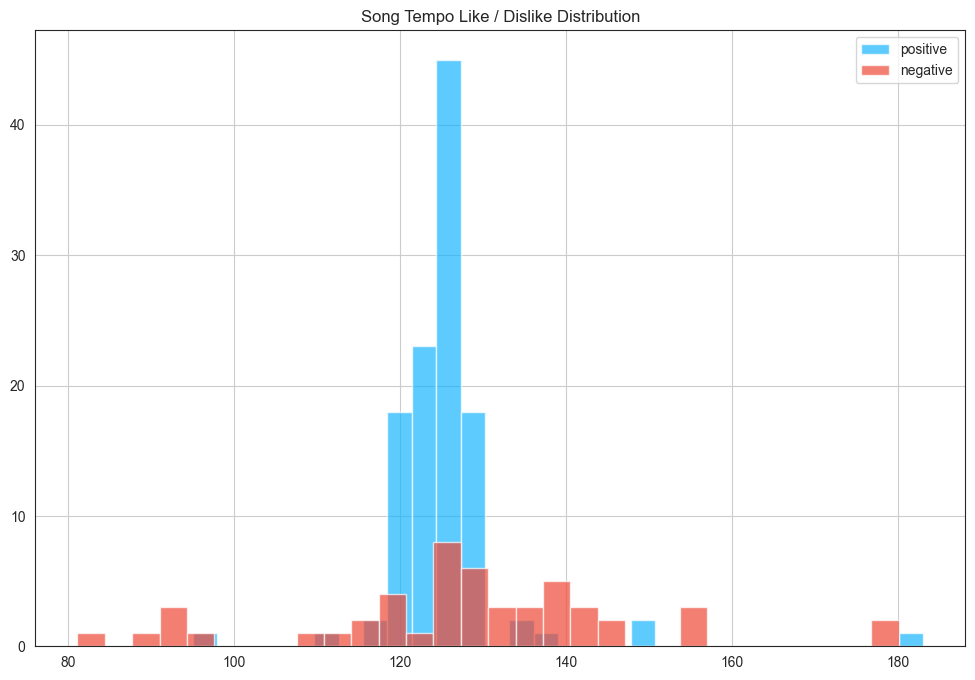

In [77]:
fig = plt.figure(figsize=(12,8))
plt.title("Song Tempo Like / Dislike Distribution")
pos_tempo.hist(alpha=0.7, bins=30, label='positive')
neg_tempo.hist(alpha=0.7, bins=30, label='negative')
plt.legend(loc='upper right')

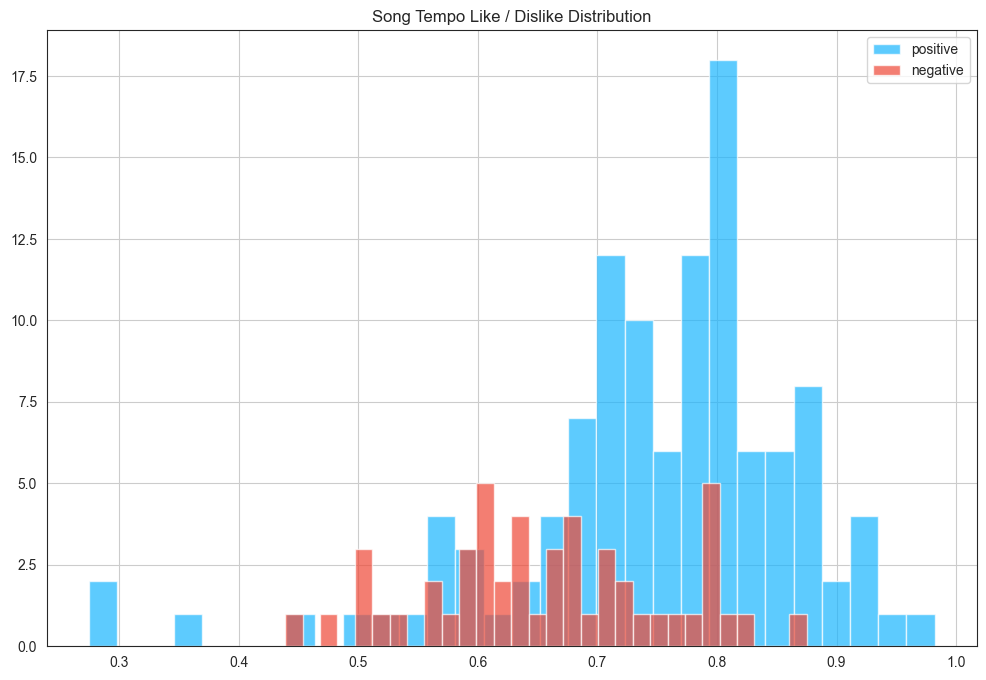

In [78]:
fig = plt.figure(figsize=(12,8))
plt.title("Song Tempo Like / Dislike Distribution")
pos_dance.hist(alpha=0.7, bins=30, label='positive')
neg_dance.hist(alpha=0.7, bins=30, label='negative')
plt.legend(loc='upper right')

<Axes: >

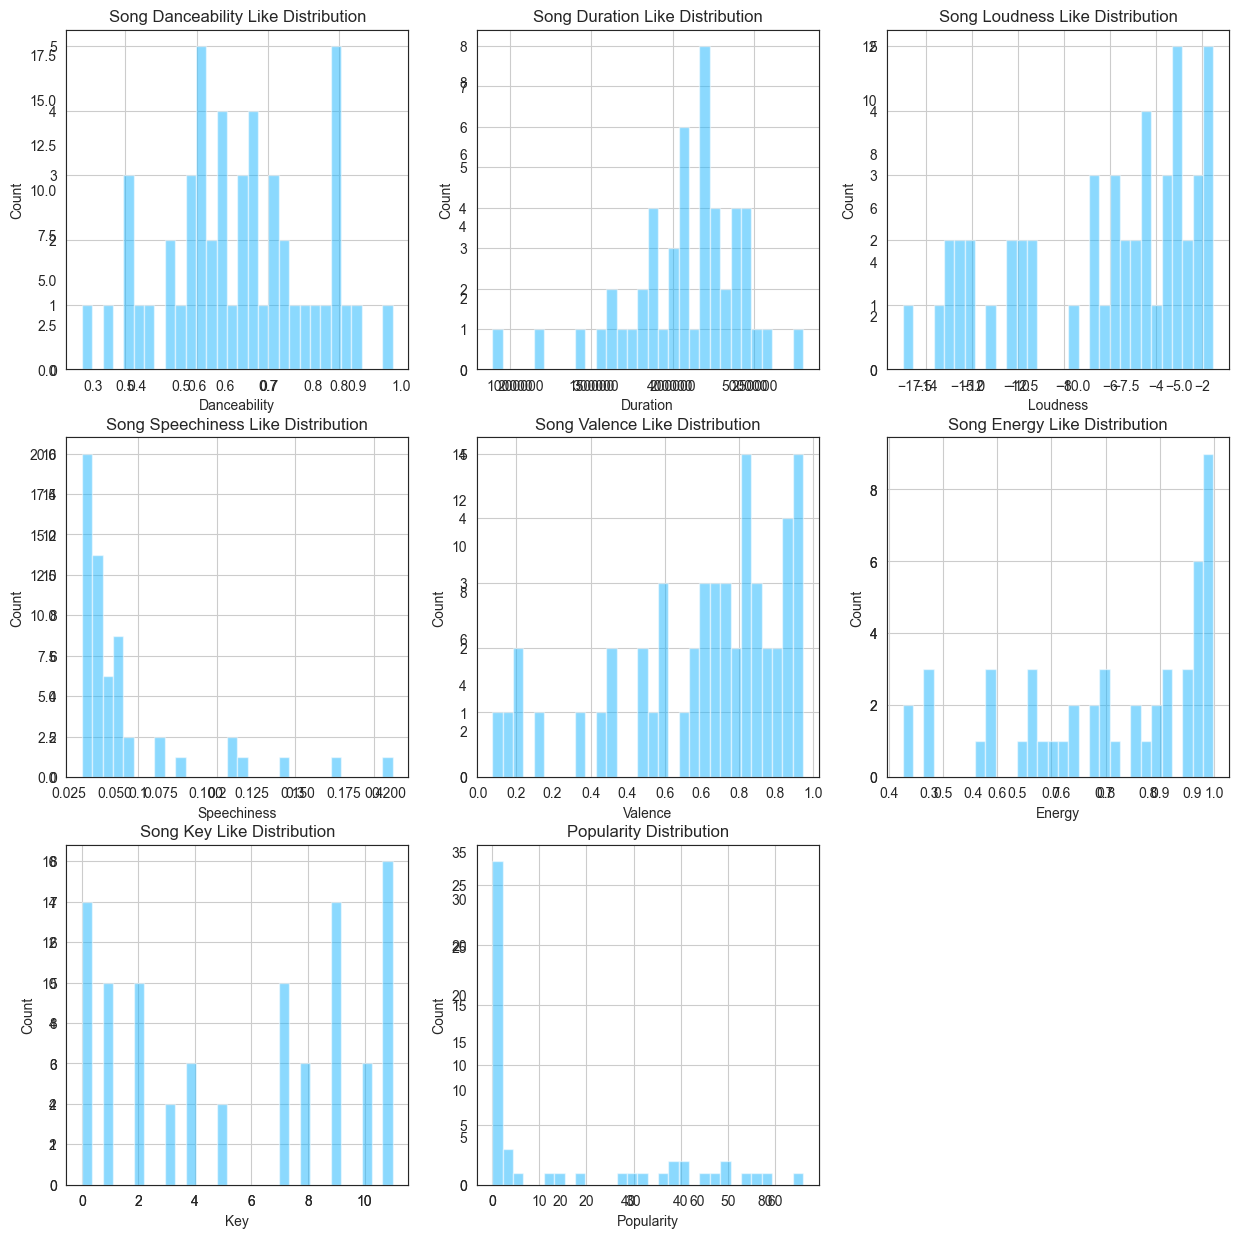

In [79]:
fig2 = plt.figure(figsize=(15,15))

#Danceability
ax3 = fig2.add_subplot(331)
ax3.set_xlabel('Danceability')
ax3.set_ylabel('Count')
ax3.set_title('Song Danceability Like Distribution')
pos_dance.hist(alpha= 0.5, bins=30)
ax4 = fig2.add_subplot(331)
neg_dance.hist(alpha= 0.5, bins=30)

#Duration_ms
ax5 = fig2.add_subplot(332)
ax5.set_xlabel('Duration')
ax5.set_ylabel('Count')
ax5.set_title('Song Duration Like Distribution')
pos_duration.hist(alpha= 0.5, bins=30)
ax6 = fig2.add_subplot(332)
neg_duration.hist(alpha= 0.5, bins=30)

#Loudness
ax7 = fig2.add_subplot(333)
ax7.set_xlabel('Loudness')
ax7.set_ylabel('Count')
ax7.set_title('Song Loudness Like Distribution')
pos_loudness.hist(alpha= 0.5, bins=30)
ax8 = fig2.add_subplot(333)
neg_loudness.hist(alpha= 0.5, bins=30)

#Speechiness
ax9 = fig2.add_subplot(334)
ax9.set_xlabel('Speechiness')
ax9.set_ylabel('Count')
ax9.set_title('Song Speechiness Like Distribution')
pos_speechiness.hist(alpha= 0.5, bins=30)
ax10 = fig2.add_subplot(334)
neg_speechiness.hist(alpha= 0.5, bins=30)

#Valence
ax11 = fig2.add_subplot(335)
ax11.set_xlabel('Valence')
ax11.set_ylabel('Count')
ax11.set_title('Song Valence Like Distribution')
pos_valence.hist(alpha= 0.5, bins=30)
ax12 = fig2.add_subplot(335)
neg_valence.hist(alpha= 0.5, bins=30)

#Energy
ax13 = fig2.add_subplot(336)
ax13.set_xlabel('Energy')
ax13.set_ylabel('Count')
ax13.set_title('Song Energy Like Distribution')
pos_energy.hist(alpha= 0.5, bins=30)
ax14 = fig2.add_subplot(336)
neg_energy.hist(alpha= 0.5, bins=30)

#Key
ax15 = fig2.add_subplot(337)
ax15.set_xlabel('Key')
ax15.set_ylabel('Count')
ax15.set_title('Song Key Like Distribution')
pos_key.hist(alpha= 0.5, bins=30)
ax16 = fig2.add_subplot(337)
neg_key.hist(alpha= 0.5, bins=30)

#Key
ax15 = fig2.add_subplot(338)
ax15.set_xlabel('Popularity')
ax15.set_ylabel('Count')
ax15.set_title('Popularity Distribution')
pos_popularity.hist(alpha= 0.5, bins=30)
ax16 = fig2.add_subplot(338)
neg_popularity.hist(alpha= 0.5, bins=30)


In [80]:
#Define the set of features that we want to look at
features = ["danceability", "loudness", "valence", "energy", "instrumentalness", "acousticness", "key", "speechiness","duration_ms"]

In [81]:
#Split the data into x and y test and train sets to feed them into a bunch of classifiers!
x_train = train[features]
y_train = train["target"]

x_test = test[features]
y_test = test["target"]

In [82]:
c = DecisionTreeClassifier(min_samples_split=100)
dt = c.fit(x_train, y_train)

In [83]:
def show_tree(InputTree, features, path):
    f = io.StringIO()
    tree.export_graphviz(InputTree, out_file=f, feature_names=features)
    pydotplus.graph_from_dot_data(f.getvalue()).write_png(path)
    img = misc.imread(path)
    plt.rcParams["figure.figsize"] = (20,20)
    plt.imshow(img)
# TODO install 
# show_tree(dt, features, "dec_tree.png")

In [84]:
y_pred = c.predict(x_test)
score = accuracy_score(y_test, y_pred) * 100
print("Accuracy using Decision Tree: ", round(score, 1), "%")

Accuracy using Decision Tree:  100.0 %


In [85]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(3)
knn.fit(x_train, y_train)
knn_pred = c.predict(x_test)
score = accuracy_score(y_test, knn_pred) * 100
print("Accuracy using Knn Tree: ", round(score, 1), "%")

Accuracy using Knn Tree:  100.0 %


In [86]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(x_train, y_train)
mlp_pred = mlp.predict(x_test)
score = accuracy_score(y_test, mlp_pred) * 100
print("Accuracy using mlp Tree: ", round(score, 1), "%")

Accuracy using mlp Tree:  68.0 %


In [87]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
forest.fit(x_train, y_train)
forest_pred = forest.predict(x_test)
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, forest_pred) * 100
print("Accuracy using random forest: ", round(score, 1), "%")

Accuracy using random forest:  96.0 %


In [88]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=100)
ada.fit(x_train, y_train)
ada_pred = ada.predict(x_test)
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, ada_pred) * 100
print("Accuracy using ada: ", round(score, 1), "%")

Accuracy using ada:  100.0 %


c:\Users\Michael\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [89]:
from sklearn.naive_bayes import GaussianNB
gauss = GaussianNB()
gauss.fit(x_train, y_train)
gauss_pred = gauss.predict(x_test)
score = accuracy_score(y_test, gauss_pred)*100
print("Accuracy using gauss: ", round(score, 1), "%")

Accuracy using gauss:  84.0 %


In [90]:
from sklearn.cluster import KMeans
k_means = KMeans(n_clusters=3, random_state=0)
k_means.fit(x_train, y_train)
predicted= k_means.predict(x_test)
score = accuracy_score(y_test, predicted)*100
print("Accuracy using Kmeans: ", round(score, 1), "%")

Accuracy using Kmeans:  60.0 %


In [91]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=.1, max_depth=1, random_state=0)
gbc.fit(x_train, y_train)
predicted = gbc.predict(x_test)
score = accuracy_score(y_test, predicted)*100
print("Accuracy using Gbc: ", round(score, 1), "%")

Accuracy using Gbc:  100.0 %


In [92]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis()
qda.fit(x_train, y_train)
qda_pred = qda.predict(x_test)
score = accuracy_score(y_test, qda_pred)*100
print("Accuracy using qda: ", round(score, 1), "%")

Accuracy using qda:  100.0 %


In [93]:
from sklearn.svm import SVC
svc_lin = SVC(kernel="linear", C=0.025)
svc_lin.fit(x_train, y_train)
svc_pred = svc_lin.predict(x_test)
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, svc_pred) * 100
print("Accuracy using svc linear: ", round(score, 1), "%")

Accuracy using svc linear:  84.0 %


In [94]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
gpc = GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True)
gpc.fit(x_train, y_train)
gpc_pred = gpc.predict(x_test)
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, gpc_pred) * 100
print("Accuracy using gpc: ", round(score, 1), "%")

Accuracy using gpc:  44.0 %


In [95]:
client_id = '164fe11263da4ce8b39cb03311385ce6'
client_secret = '448a0146206e4b718e4bcc0865efcd29'
redirect_uri='http://localhost:8080/callback'
username = '5865b9eadfc54092'
scope = 'playlist-modify-private playlist-modify-public playlist-read-private user-library-read'


#Credentials to access the Spotify Music Data
from spotipy.oauth2 import SpotifyOAuth
import spotipy

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id,
                                               client_secret,
                                               redirect_uri,
                                               scope = 'user-library-read playlist-read-private'))

In [96]:
# https://open.spotify.com/playlist/37i9dQZEVXboFaKVZ0SRxM?si=5461b1f5714646cb
playlistToFindSongsYouLikeIn = sp.user_playlist("spotify", "37i9dQZEVXboFaKVZ0SRxM")

newPlaylist_tracks = playlistToFindSongsYouLikeIn["tracks"]
newPlaylist_songs = newPlaylist_tracks["items"] 
while newPlaylist_tracks['next']:
    newPlaylist_tracks = sp.next(newPlaylist_tracks)
    for song in newPlaylist_tracks["items"]:
        newPlaylist_songs.append(song)
        
newPlaylist_song_ids = [] 
print(len(newPlaylist_songs))
for i in range(len(newPlaylist_songs)):
    newPlaylist_song_ids.append(newPlaylist_songs[i]['track']['id'])
    
newPlaylist_features = []
j = 0
for i in range(0,len(newPlaylist_song_ids),50):
    audio_features = sp.audio_features(newPlaylist_song_ids[i:i+50])
    for track in audio_features:
        track['song_title'] = newPlaylist_songs[j]['track']['name']
        track['artist'] = newPlaylist_songs[j]['track']['artists'][0]['name']
        j= j + 1
        newPlaylist_features.append(track)
print(len(newPlaylist_features))

playlistToLookAtFeatures = pd.DataFrame(newPlaylist_features)

30
30


In [97]:
# https://open.spotify.com/playlist/7FoNW55Sdf38eY23BcQCDp?si=f6b9b38b8bd74613

pred = gbc.predict(playlistToLookAtFeatures[features])

to_add = []

likedSongs = 0
i = 0
for prediction in pred:
    if(prediction == 1):
        print ("Song: " + playlistToLookAtFeatures["song_title"][i] + ", By: "+ playlistToLookAtFeatures["artist"][i] + " id : " + playlistToLookAtFeatures["id"][i])
        print(type(playlistToLookAtFeatures["id"][i]))
        to_add.append(playlistToLookAtFeatures['id'][i])
        likedSongs = likedSongs + 1
    i = i + 1

Song: Past Lives - K-391 Remix, By: sapientdream id : 1APXWw9eO8Ude1penQhcaj
<class 'str'>
Song: Europaträume, By: Brutalismus 3000 id : 0PYX7X0wTBT5WvKzNCWtk2
<class 'str'>
Song: Ausreden, By: makko id : 6ocEdv3r2yASPGP7moFUeZ
<class 'str'>
Song: Furia Electronica, By: Worakls id : 5cHjMM0sX3nOME4JHIJfJq
<class 'str'>
Song: Symphony, By: Solveno id : 4w0Ocbf7XKcwrM34TSTezK
<class 'str'>
Song: Rumble Strip, By: Ben Howard id : 1FSS2KFXMpXYmfWga8gDxZ
<class 'str'>
Song: Trust You (DIØN Remix), By: Yellow Claw id : 6r9SwEhH0sbBVhvtOcStHe
<class 'str'>
Song: Press Play (feat. Future), By: Nicki Minaj id : 412SI13OfbJ6cpg2XYCtzz
<class 'str'>
Song: ELECTROWAVEBABY, By: Kid Cudi id : 0FUxvg2CUPXZaDhHl1vd4V
<class 'str'>
Song: Miroir Miroir - Romain Garcia Remix, By: CRi id : 0Ysm1TAJq3jUFPHbOGN9lL
<class 'str'>
Song: X & CUD (with XXXTENTACION), By: Kid Cudi id : 387j61utwXNE7Bvi5UTR2k
<class 'str'>
Song: Kein Drama, By: Chakuza id : 20iDbGnkBrym9DgFK0HX0m
<class 'str'>


In [98]:
to_add

['1APXWw9eO8Ude1penQhcaj',
 '0PYX7X0wTBT5WvKzNCWtk2',
 '6ocEdv3r2yASPGP7moFUeZ',
 '5cHjMM0sX3nOME4JHIJfJq',
 '4w0Ocbf7XKcwrM34TSTezK',
 '1FSS2KFXMpXYmfWga8gDxZ',
 '6r9SwEhH0sbBVhvtOcStHe',
 '412SI13OfbJ6cpg2XYCtzz',
 '0FUxvg2CUPXZaDhHl1vd4V',
 '0Ysm1TAJq3jUFPHbOGN9lL',
 '387j61utwXNE7Bvi5UTR2k',
 '20iDbGnkBrym9DgFK0HX0m']

In [99]:
sp.user_playlist_add_tracks("5865b9eadfc54092", "7FoNW55Sdf38eY23BcQCDp", to_add)

{'snapshot_id': 'Myw5ODE1MzkyNjk1NjAyNWJhYjFiYTdkOWVmOWVjMDY4YjUxZDY4NjBj'}